In [1]:
import os
import scipy.io as sio
# 切换到包含文件的目录
os.chdir('/Users/gengxingri/Desktop/Leetcodes/HUAWEI')

from decimal import Decimal
import numpy as np

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import eigsh, norm, spsolve, cg, minres
import scipy.sparse as sp
import scipy.sparse.linalg as sla

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import time


In [2]:
# 读取.mat 文件
data = sio.loadmat('raefsky4.mat')


A = data['Problem']['A'][0][0]
print(A.shape, type(A))

b = data['Problem']['b'][0][0]
print(b.shape, type(b))



(19779, 19779) <class 'scipy.sparse._csc.csc_matrix'>
(19779, 1) <class 'numpy.ndarray'>


In [3]:
'''
tol 的值可以优化来提高eigval_min 的精度，但是算法的时间会增加
'''
# Calculate the condition number
start_time = time.time()

# return eigenvalues that have the min and max abs values, respectively
eigval_max = eigsh(A, k=1, which='LM', return_eigenvectors=False)[0]
eigval_min = eigsh(A, k=1, which='SM', return_eigenvectors=False, tol=5)[0]
print(eigval_min, eigval_max)

condition_number = eigval_max / eigval_min

print("Condition number based on eigenvalues:", condition_number)

end_time = time.time()
execution_time = end_time - start_time

print(f"Runing time：{execution_time} s")

348.7472370705025 266693679433.4216
Condition number based on eigenvalues: 764719117.7015891
Runing time：16.925386905670166 s


In [4]:
# Create the diagonal preconditioner
n = A.shape[0]
diag_A = A.diagonal()

D = csc_matrix((1 / np.sqrt(diag_A), (np.arange(n), np.arange(n))), shape=(n, n))

# Apply preconditioning
A_new = D.dot(A.dot(D))

# 将 numpy 数组转换为 CSC 格式的稀疏矩阵
b_sparse = csc_matrix(b)

b_new = D.dot(b_sparse) / norm(D.dot(b_sparse)) 

print(A_new.diagonal(), norm(b_new))

[1. 1. 1. ... 1. 1. 1.] 1.0


In [5]:
'''
tol 的值可以优化来提高eigen_val 的精度，但是算法的时间会增加
'''

# Calculate the condition number

eigval_max = eigsh(A_new, k=1, which='LM', return_eigenvectors=False)[0]
eigval_min = eigsh(A_new, k=1, which='SM', return_eigenvectors=False, tol=5)[0]
print(eigval_min, eigval_max)

preconditioned_cond = eigval_max / eigval_min

print("Condition number based on eigenvalues:", preconditioned_cond)


3.031724988807599e-09 5.5409525529493155
Condition number based on eigenvalues: 1827656721.307237


In [6]:
# Unique solution of Ax = b

x_unique = spsolve(A_new, b_new)
print(x_unique)

[-58205.27446283  -5258.44764142 -98824.13029583 ...   1593.54954083
 -12645.61451808    113.03627155]


In [7]:
# CG mtheod

def conjugate_gradient_sparse(A, b, tol=1e-8, max_iter=5*b.shape[0]):
    n = b.shape[0] 
    x = np.zeros(n).reshape((n,1))
    r = b - A @ x
    #print(r.shape, type(r))
    xk_cg =[]
    
    
    p = r.copy()
    r_norm_sq = np.dot(r.T,r)
    errors = []  # Initial error
    #print(x.shape, r_norm_sq.shape)

    for i in range(max_iter):
        i += 1
        Ap = A @ p
        alpha = r_norm_sq / np.dot(p.T, Ap)
        x = x + alpha * p
        r -= alpha * Ap
        
        r_norm_sq_new = np.dot(r.T, r)
        
        
        errors.append(np.sqrt(r_norm_sq_new))  
        xk_cg.append(x)
            
        if np.sqrt(r_norm_sq_new) < tol:
            print(f"Converged after {i} iterations")
            return x, errors, xk_cg
        
        beta = r_norm_sq_new / r_norm_sq
        p = r + beta * p
        r_norm_sq = r_norm_sq_new
    
    print(f"Did not converge after {max_iter} iterations")
    return x, errors, xk_cg

# Solve using our CG implementation
start_time = time.time()

b_array = b_new.toarray()
x_cg, errors, xk = conjugate_gradient_sparse(A_new, b_array, tol=1e-12)

cg_time = time.time() - start_time

print(f"CG method took {cg_time:.4f} seconds")

# change the type of errors_cg and xk_cg
errors_cg = [arr[0][0] for arr in errors]
xk_cg = [np.reshape(arr,-1) for arr in xk]

Did not converge after 98895 iterations
CG method took 227.8898 seconds


In [9]:
# MINRES method

errors_minres = []
xk_minres = []

def callback(xk):
    rk = b_array - A_new.dot(xk).reshape(-1, 1)
    error_norm = np.linalg.norm(rk)
    errors_minres.append(error_norm)
    xk_minres.append(xk)
        
    return error_norm

x_minres, info_minres = minres(A_new, b_array, tol=1e-20, maxiter=5*b.shape[0], callback=callback)

print(len(errors_minres))

55212


'\n\ndef minres_method(A, b, max_iter=5*b.shape[0], tol=1e-8):\n    n = len(b)\n    x = np.zeros(n)\n    \n    r = b - A @ x\n    p = r.copy()\n    r_norm_sq = np.dot(r, r)\n    \n    beta = np.linalg.norm(r)\n    v = r / beta\n    \n    w_old = np.zeros(n)\n    w = np.zeros(n)\n    \n    residuals = [] \n    xk = []\n    \n    for i in range(max_iter):\n        \n        # Lanczos process\n        v_new = A @ v - beta * w_old\n        alpha = np.dot(v, v_new)\n        w = v_new - alpha * v\n        \n        beta_new = np.linalg.norm(w)\n        w /= beta_new\n        \n        # Givens rotation\n        rho = np.sqrt(alpha**2 + beta_new**2)\n        c = alpha / rho\n        s = beta_new / rho\n        \n        # Update solution and residual\n        d = (beta * c) / rho\n        x += d * v\n        r -= d * A @ v\n        \n        # Prepare for next iteration\n        w_old = w.copy()\n        v_old = v.copy()\n        v = w / beta_new\n        beta = beta_new\n        \n        re

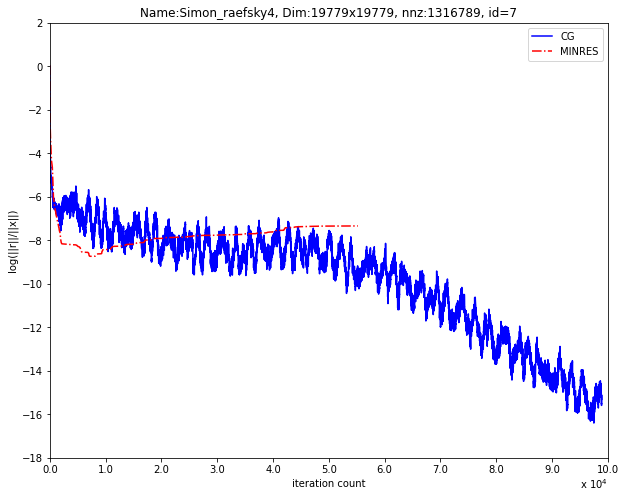

In [10]:
'''
这里图形和原文章中的图形有点不一样是因为，直接调用python自带的算法minres,跑了55212次就收敛了，原文章跑了10万次没有收敛
'''

# Plot the log(||r||/||x||) errors

xk_cg_norms =  np.array([np.linalg.norm(xk) for xk in xk_cg])
xk_minres_norms =  np.array([np.linalg.norm(xk) for xk in xk_minres])

cg_errors = np.log10(errors_cg / xk_cg_norms) 
minres_errors = np.log10(errors_minres / xk_minres_norms)

def plot_log(cg_errors, minres_errors):
    # Create the plot
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(range(1,len(cg_errors)+1), cg_errors, 'b-', label='CG')
    ax.plot(range(1,len(minres_errors)+1), minres_errors, 'r-.', label='MINRES')

    # Set labels and title
    ax.set_xlabel('iteration count')
    ax.text(1, -0.06, 'x $10^4$', transform=ax.transAxes, ha='right', va='center')
    
    ax.set_ylabel('log(||r||/||x||)')
    ax.set_title('Name:Simon_raefsky4, Dim:19779x19779, nnz:1316789, id=7')

    # Set x-axis limits
    ax.set_xlim(0, 100000)
    ax.set_xticks(np.arange(0, 100001, 10000))
    ax.set_xticklabels([f'{i/10000}' for i in np.arange(0, 100001, 10000)])
    
    ax.set_ylim(-18, 2)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

    # Add legend
    ax.legend()


    # Show the plot
    plt.show()

plot_log(cg_errors, minres_errors)

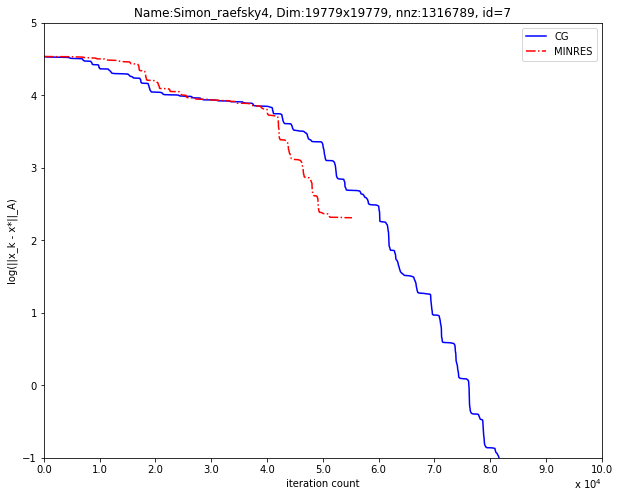

In [11]:
# Plot the log(||xk-x*||_A) errors

def plot_A_norm(cg_errors, minres_errors):
    # Create the plot
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(range(1, len(cg_errors)+1), cg_errors, 'b-', label='CG')
    ax.plot(range(1, len(minres_errors)+1), minres_errors, 'r-.', label='MINRES')

    # Set labels and title
    ax.set_xlabel('iteration count')
    ax.text(1, -0.06, 'x $10^4$', transform=ax.transAxes, ha='right', va='center')
    
    
    ax.set_ylabel('log(||x_k - x*||_A)')
    ax.set_title('Name:Simon_raefsky4, Dim:19779x19779, nnz:1316789, id=7')

    # Set x-axis limits
    ax.set_xlim(0, 100000)
    ax.set_xticks(np.arange(0, 100001, 10000))
    ax.set_xticklabels([f'{i/10000}' for i in np.arange(0, 100001, 10000)])
    ax.set_ylim(-1, 5)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Add legend
    ax.legend()


    # Show the plot
    plt.show()
    
# errors of log||xk - x* ||_A in each iteration

errors_iter_cg = [np.sqrt((xk - x_unique).T.dot(A_new.dot(xk - x_unique))) for xk in xk_cg]
xk_A_norms_cg = [np.array(err) for err in errors_iter_cg]

#print('\nErrors of cg:', xk_A_norms_cg[0:5])
cg_errors_A_norm = np.log10(xk_A_norms_cg)



# errors of minres

errors_iter_minres = [np.sqrt((xk - x_unique).T.dot(A_new.dot(xk - x_unique))) for xk in xk_minres] # list of array
xk_A_norms_minres = [np.array(err) for err in errors_iter_minres]
minres_errors_A_norm = np.log10(xk_A_norms_minres)
#print('\nErrors of minres:', xk_A_norms_minres[0:5])

# plot
plot_A_norm(cg_errors_A_norm, minres_errors_A_norm)


Errors of minres: [array(6.08868042e+09), array(6.08868042e+09), array(6.08868042e+09), array(6.08868041e+09), array(6.08868035e+09)]


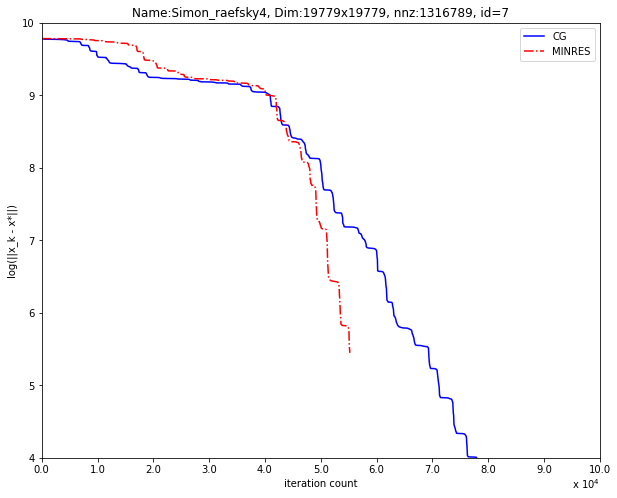

In [12]:
# Plot the log(||xk-x*||) errors

def plot_norm(cg_errors, minres_errors):
    # Create the plot
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(range(1, len(cg_errors)+1), cg_errors, 'b-', label='CG')
    ax.plot(range(1, len(minres_errors)+1), minres_errors, 'r-.', label='MINRES')

    # Set labels and title
    ax.set_xlabel('iteration count')
    ax.text(1, -0.06, 'x $10^4$', transform=ax.transAxes, ha='right', va='center')
    
    ax.set_ylabel('log(||x_k - x*||)')
    ax.set_title('Name:Simon_raefsky4, Dim:19779x19779, nnz:1316789, id=7')

    # Set x-axis limits
    ax.set_xlim(0, 100000)
    ax.set_xticks(np.arange(0, 100001, 10000))
    ax.set_xticklabels([f'{i/10000}' for i in np.arange(0, 100001, 10000)])
    
    ax.set_ylim(4, 10)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Add legend
    ax.legend()


    # Show the plot
    plt.show()

# errors of log||xk - x* || in each iteration

# errors of cg
errors3_cg = [np.linalg.norm(xk - x_unique) for xk in xk_cg]
errors_norm3_cg = [np.array(err) for err in errors3_cg]

#print('\nErrors of minres:', errors_norm3_cg[0:5])
cg_errors_norm3 = np.log10(errors_norm3_cg)


# errors of minres

errors3_minres = [np.linalg.norm(xk - x_unique) for xk in xk_minres]
errors_norm3_minres = [np.array(err) for err in errors3_minres]

#print('\nErrors of minres:', errors_norm3_minres[0:5])
minres_errors_norm3 = np.log10(errors_norm3_minres)

#print('\nErrors of minres:', minres_errors_norm3[0:5])


# plot
plot_norm(cg_errors_norm3, minres_errors_norm3)